# Evoluční algoritmy - Genetické programování

Dneska se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

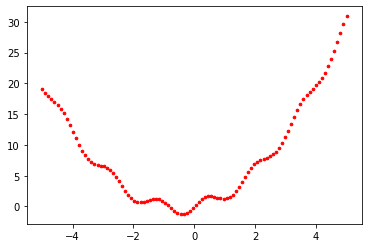

In [2]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ jedinců, šla by použít i netypovaná verze. Jako terminály si definujeme konstanty 0,1,2, zbytek se dovytvoří z nich během evoluce. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [3]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)


# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(np.cos, [float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Jedince vygenerujeme jako náhodné stromy z množiny primitiv a nastavíme jim počáteční minimální a maximální hloubku. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou, tedy čtvercovou vzdálenost jak daleko je predikovaný výstup od skutečného. Nastavíme jí váhu -1, protože chceme chybu minimalizovat. Zároveň nastavíme i váhu -0.01, která penalizuje počet uzlů ve stromu, abychom evoluci nutili k vytváření spíše menších jedinců. Selekci použijeme turnajovou, křížení jednobodové, kdy se klasicky náhodně zvolí bod a v něm se prohodí části podstromů, a uniformní mutaci, která náhodně vybere místo v jedinci a nahradí podstrom za kořen výrazu vygenerovanou pomocí metody ```expr()``` na základě definovaných operací a konstant. Zároveň přidáme limity na hloubku stromu pri křížení a mutaci, aby nám stromy zbytečně nebobtnaly.

In [4]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus genetického programování pustit.

In [5]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min    	nevals	std    	avg   	gen	max	min	nevals	std    
0  	1000  	2371.95	0  	1.25547e+06	8.43468	1000  	45096.6	60.841	0  	861	4  	1000  	102.669
1  	541   	113.319	1  	2476.13    	7.03293	541   	77.2314	44.583	1  	859	2  	541   	82.3027
2  	558   	103.493	2  	660.059    	7.03293	558   	33.0907	31.176	2  	528	2  	558   	46.9543
3  	566   	161.471	3  	66608.3    	7.03293	566   	2102.93	27.201	3  	382	2  	566   	31.3385
4  	571   	87.8886	4  	3389.78    	7.03293	571   	131.379	24.532	4  	198	3  	571   	17.056 
5  	563   	76.599 	5  	5505.25    	7.03293	563   	190.002	24.914	5  	129	2  	563   	12.4471
6  	559   	62.9023	6  	4330.6     	7.03293	559   	179.533	26.895	6  	65 	3  	559   	12.2671
7  	578   	39.0843	7  	929.351    

83 	532   	69.2145	83 	7045.59    	7.03293    	532   	307.039	5.436 	83 	19 	2  	532   	1.88518
84 	575   	65.2833	84 	4666.95    	7.03293    	575   	224.043	5.505 	84 	19 	3  	575   	2.10047
85 	538   	63.8213	85 	3545.34    	7.03293    	538   	166.662	5.415 	85 	18 	2  	538   	1.98211
86 	546   	54.9977	86 	500.072    	7.03293    	546   	111.825	5.394 	86 	17 	2  	546   	1.79688
87 	537   	60.0415	87 	2038.7     	7.03293    	537   	147.472	5.513 	87 	19 	2  	537   	2.04397
88 	590   	65.6413	88 	552.742    	7.03293    	590   	123.668	5.516 	88 	20 	2  	590   	2.13161
89 	531   	59.5227	89 	912.924    	7.03293    	531   	120.058	5.5   	89 	18 	2  	531   	2.06155
90 	528   	63.5975	90 	4145.14    	7.03293    	528   	174.849	5.47  	90 	18 	2  	528   	1.95732
91 	572   	70.3565	91 	12929.8    	7.03293    	572   	423.28 	5.412 	91 	19 	2  	572   	2.03476
92 	497   	50.7642	92 	1018.05    	7.03293    	497   	116.901	5.373 	92 	18 	2  	497   	1.79049
93 	536   	55.7312	93 	980.271    	7.032

Vidíme, že výstup výše je sice krásný a určitě bohatě vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [6]:
# zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

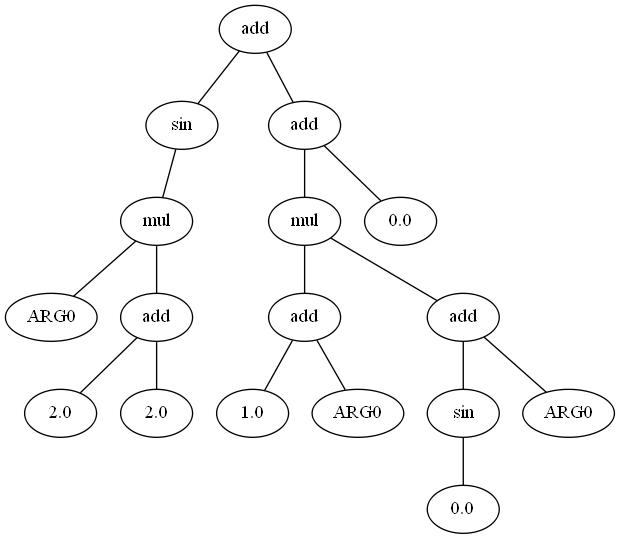

In [7]:
Image(plot_tree(hof[0]))

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům. Když máme štěstí na dobrý běh tak vidíme, že se nám podařilo nalézt funkci téměř ideálně pasující na naše data.

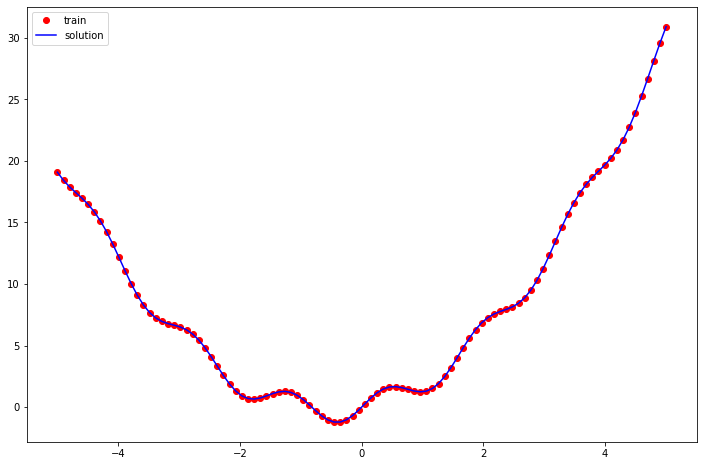

In [8]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte je a pusťte genetické programování.